In [1]:
%pip install tf-agents[reverb]==0.19.0
%pip install yfinance==0.2.37
%pip install ta==0.11.0
%pip install pyarrow==11.0.0

#Usually already available
# %pip install pandas_ta
# %pip install tqdm
# %pip install scikit-learn
# %pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697628 sha256=8c31e295b4ed6dc70efb10ec3333a6de24026fca2a3d7244ee1d7f9ac93642d8
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting u

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents

import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    from google.colab import files
    from google.colab import drive

    IN_COLAB = True
    GDRIVE = '/content/drive'
    drive.mount(GDRIVE)
    print("Mounted on COLLAB")
except:
    GDRIVE = None
    IN_COLAB = False
    files = None
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle...')

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
    IN_KAGGLE = True
else:
    IN_KAGGLE = False
    DATA_DIR = "./data/"

Running in Kaggle...


In [3]:
import tensorflow as tf
import tf_agents as tfa

from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import sequential
from tf_agents.metrics import py_metrics, tf_metrics
from tf_agents.policies import greedy_policy, py_tf_eager_policy, random_py_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils, py_uniform_replay_buffer, tf_uniform_replay_buffer
from tf_agents.train import learner, triggers
from tf_agents.train.utils import spec_utils, strategy_utils, train_utils
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.policies import random_py_policy, py_tf_eager_policy, policy_saver, random_tf_policy
from tf_agents.eval import metric_utils
from tf_agents.drivers import py_driver, dynamic_episode_driver, dynamic_step_driver

import numpy as np
import math
import shutil
import yfinance as yf
import pandas as pd
import IPython
import pyarrow
import reverb

from datetime import datetime

from scipy.stats import skew, kurtosis
from ta.utils import dropna
from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if ('COLAB_TPU_ADDR' in os.environ and IN_COLAB) or (IN_KAGGLE and 'TPU_ACCELERATOR_TYPE' in os.environ):
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
elif len(tf.config.list_physical_devices('GPU')) > 0:
    strategy = tf.distribute.MirroredStrategy()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("Number of accelerators:", strategy.num_replicas_in_sync)

os.getcwd()

2024-03-20 16:12:44.676254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 16:12:44.676400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 16:12:44.831251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running on CPU
Number of accelerators: 1


'/kaggle/working'

In [4]:
import pytz
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay, Day

DATA_DIR = "./data"
INDEX = "Date"
MIN1_RANGE = 7 - 1
MIN15_RANGE = 60 - 1
HOUR_RANGE = 730 - 1
DAY_RANGE = 7300 - 1
D1="1d"
H1="1h"
M15="15m"
M1="1m"
EVAL_SPLIT = 0.2
DATE_TIME_FORMAT = "%Y-%m-%d"
START_DATE = pd.Timestamp(datetime.now() - Day(MIN15_RANGE)).strftime(DATE_TIME_FORMAT)
END_DATE = pd.Timestamp(datetime.now() - BDay(1)).strftime(DATE_TIME_FORMAT)
total_days = (pd.Timestamp(END_DATE) - pd.Timestamp(START_DATE)).days
midpoint_date = pd.Timestamp(START_DATE) + Day(int(total_days * EVAL_SPLIT))
SPLIT_DATE = midpoint_date.strftime(DATE_TIME_FORMAT)

SNP_FUT = "ES=F" # E-min SnP futures
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
SMALLCAP_INDEX = "^RUT" # Russell 2000 Index
GOLD_INDEX = "GC=F" # Gold futures
MARKET = "^SPX" # SnP
TECH = "^IXIC" # Nasdaq
CRUDOIL_FUT="CL=F"
BTC='BTC-USD'
SHORTVOL='^SHORTVOL'
TARGET = MARKET
TICKER_SYMBOLS = [TARGET, RATES_INDEX, VOLATILITY_INDEX, SMALLCAP_INDEX, GOLD_INDEX, TECH, SNP_FUT, CRUDOIL_FUT, BTC, SHORTVOL]

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_NEUTRAL = 3 # Added this action to go to neutral and wait
ACT_HOLD = 2
ACT_LONG = 1
ACT_SHORT = 0
ACTIONS = [ACT_SHORT, ACT_LONG]

CAPITAL = 100000
TRADE_COSTS_PERCENT = 25 / 100 / 100 # 25BPS costs

MACRO_FEATURES = [RATES_INDEX, VOLATILITY_INDEX, SMALLCAP_INDEX, GOLD_INDEX, TECH, SNP_FUT, BTC, SHORTVOL]
TA_FEATURES = ['MACD', 'MACD_HIST', 'MACD_SIG', 'ATR']
FEATURES = ["Close", "High", "Low", "Open", "Volume"]
TARGET_FEATURE = "Price Raw"
STATE_LEN = 4*8 # Past 30 timesteps
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = len(ACTIONS)

LEARN_RATE = 1e-3
TOTAL_ITERS = 50 # 400
TARGET_UPDATE = max(TOTAL_ITERS // 4, 10)
TRAIN_EPISODES = TOTAL_ITERS * 20
INIT_COLLECT = 100
COLLECT_STEPS = 1
LOG_INTERVALS = max(int(TOTAL_ITERS / 2), 2)
TEST_INTERVALS = max(int(TOTAL_ITERS / 1.5), 10)
EVAL_EPISODES = max(int(TEST_INTERVALS / 2), 10)

BATCH_SIZE = 32 * strategy.num_replicas_in_sync
MEMORY_LENGTH = 100000
DISCOUNT = .65 # Short term gains < 5 or long > 5
EPSILON_START = 1.
EPSILON_END = 0.01
EPSILON_DECAY = 60.

GRAD_CLIP = 1
REWARD_CLIP = 1
PUNISHMENT = 1.05 # Increase the negative 'reward'
REWARD_SCALE = 1.0
CHECKPOINT_INTERVAL = max(TOTAL_ITERS // 5, 10)

DROPOUT = 0.5
L2FACTOR = 0.000025
NEURONS = 512
LAYERS = (NEURONS,) * 6

In [5]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=M15, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=interval,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)

from ta.utils import dropna
from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

stock_df = tickers[TARGET].copy()

macd = MACD(close=stock_df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
stock_df['MACD'] = macd.macd()
stock_df['MACD_HIST'] = macd.macd_diff()
stock_df['MACD_SIG'] = macd.macd_signal()

atr = AverageTrueRange(stock_df["High"], stock_df["Low"], stock_df["Close"], window = 14, fillna = True)
stock_df['ATR'] = atr.average_true_range()

ema = EMAIndicator(stock_df["Close"], window = 14, fillna = True)
stock_df['EMA'] = ema.ema_indicator()

stock_df[VOLATILITY_INDEX] = tickers[VOLATILITY_INDEX]["Close"]
stock_df[RATES_INDEX] = tickers[RATES_INDEX]["Close"]
stock_df[SMALLCAP_INDEX] = tickers[SMALLCAP_INDEX]["Close"]
stock_df[GOLD_INDEX] = tickers[GOLD_INDEX]["Close"]
stock_df[TECH] = tickers[TECH]["Close"]
stock_df[SNP_FUT] = tickers[SNP_FUT]["Close"]
stock_df[CRUDOIL_FUT] = tickers[CRUDOIL_FUT]["Close"]
stock_df[BTC] = tickers[BTC]["Close"]
stock_df[SHORTVOL] = tickers[SHORTVOL]["Close"]

stock_df = stock_df.bfill().ffill()
stock_df

^SPX => min_date: 2024-01-22 09:30:00, max_date: 2024-03-18 15:45:00, kurt:-1.28, skewness:-0.11, outliers_count:0,  nan_count: 0
^TNX => min_date: 2024-01-22 08:15:00, max_date: 2024-03-18 14:45:00, kurt:0.39, skewness:-0.6, outliers_count:0,  nan_count: 0
^VIX => min_date: 2024-01-22 02:15:00, max_date: 2024-03-18 15:00:00, kurt:0.55, skewness:0.65, outliers_count:4,  nan_count: 0
^RUT => min_date: 2024-01-22 09:30:00, max_date: 2024-03-18 15:45:00, kurt:-1.17, skewness:-0.01, outliers_count:0,  nan_count: 0
GC=F => min_date: 2024-01-21 18:00:00, max_date: 2024-03-18 23:45:00, kurt:-0.68, skewness:0.96, outliers_count:0,  nan_count: 0
^IXIC => min_date: 2024-01-22 09:30:00, max_date: 2024-03-18 15:45:00, kurt:-1.14, skewness:-0.2, outliers_count:0,  nan_count: 0
ES=F => min_date: 2024-01-21 18:00:00, max_date: 2024-03-18 23:45:00, kurt:-1.09, skewness:-0.01, outliers_count:0,  nan_count: 0
CL=F => min_date: 2024-01-21 18:00:00, max_date: 2024-03-18 23:45:00, kurt:0.03, skewness:-0.36

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,EMA,^VIX,^TNX,^RUT,GC=F,^IXIC,ES=F,CL=F,BTC-USD,^SHORTVOL
Datetime,,,,,,,,,,,,,,,,,,,,
2024-01-22 09:30:00,4853.419922,4864.600098,4853.419922,4860.450195,4860.450195,348033479,0.000000,0.000000,0.000000,0.000000,4860.450195,13.52,4.100,1968.847412,2019.699951,15378.285156,4890.75,74.419998,40923.679688,2491.868896
2024-01-22 09:45:00,4860.410156,4867.859863,4859.169922,4866.629883,4866.629883,232630982,0.492967,0.394373,0.098593,0.000000,4861.274154,13.58,4.088,1978.796021,2024.400024,15432.031250,4896.00,74.279999,40703.117188,2500.268555
2024-01-22 10:00:00,4866.750000,4868.410156,4859.069824,4865.520020,4865.520020,235854600,0.785040,0.549157,0.235883,0.000000,4861.840269,13.52,4.080,1979.250610,2026.500000,15423.947266,4895.50,74.370003,40741.914062,2500.268555
2024-01-22 10:15:00,4865.470215,4866.399902,4858.759766,4859.029785,4859.029785,196520082,0.487187,0.201043,0.286143,0.000000,4861.465538,13.43,4.079,1981.850952,2028.000000,15379.114258,4889.75,74.769997,40380.542969,2507.828369
2024-01-22 10:30:00,4859.200195,4859.439941,4853.180176,4856.129883,4856.129883,199276356,0.016942,-0.215361,0.232303,0.000000,4860.754117,13.46,4.084,1975.219238,2026.599976,15368.476562,4886.25,74.699997,40519.679688,2491.868896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18 14:45:00,5155.709961,5158.870117,5154.370117,5158.339844,5158.339844,88276850,4.720434,-1.749691,6.470125,7.245835,5158.570639,14.39,4.340,2035.515259,2163.000000,16148.540039,5222.75,82.830002,66798.445312,2633.895020
2024-03-18 15:00:00,5158.379883,5161.819824,5156.819824,5160.740234,5160.740234,98399548,4.509933,-1.568154,6.078087,7.085418,5158.859918,14.33,4.340,2035.368164,2163.800049,16158.572266,5224.75,82.970001,66746.296875,2633.895020
2024-03-18 15:15:00,5160.709961,5161.899902,5158.350098,5159.390137,5159.390137,124108362,4.185915,-1.513738,5.699653,6.832874,5158.930614,14.33,4.340,2033.148560,2164.300049,16151.525391,5223.25,83.080002,66950.289062,2632.865479


In [6]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES + TA_FEATURES + MACRO_FEATURES, money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT, reward_discount=DISCOUNT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = features
        self.data_dim = len(self.features)
        self.state_length = state_length
        self.current_step = self.state_length
        self.reward_discount = reward_discount

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length * self.data_dim, ), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def BATCH_SIZE(self):
        return None #self._batch_size

    @BATCH_SIZE.setter
    def BATCH_SIZE(self, size):
        self._BATCH_SIZE = size

    def preprocess_data(self, df):
        def _log_rets(df):
            log_returns = np.log(df / df.shift(1))
            df = (log_returns - log_returns.mean()) / log_returns.std()
            df = df.dropna()
            return df

        def min_max_scale_tensor(tensor):
            min_val = tf.reduce_min(tensor)
            max_val = tf.reduce_max(tensor)
            return (tensor - min_val) / (max_val - min_val)

        price_raw = df['Close'].copy()
        for col in self.features:
            # if col in TA_FEATURES:
            #    continue
            tensor = tf.convert_to_tensor(df[col], dtype=tf.float32)
            normalized_tensor = min_max_scale_tensor(tensor)
            df[col] = normalized_tensor.numpy()

        df = df.replace(0.0, np.nan)
        df = df.interpolate(method='linear', limit=5, limit_area='inside')
        df = df.ffill().bfill().fillna(0)

        df[TARGET_FEATURE] = price_raw
        df['Sharpe'] = 0
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Returns'] = 0.
        df['Reward'] = 0.

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = self.state_length
        self._episode_ended = False
        self.total_shares = 0

        self.data['Reward'] = 0.
        self.data['Sharpe'] = 0.
        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step and history length."""
        start_idx = max(0, self.current_step - self.state_length + 1)
        end_idx = self.current_step + 1
        obs = self.data[self.features].iloc[start_idx:end_idx]

        # flatten because: https://stackoverflow.com/questions/67921084/dqn-agent-issue-with-custom-environment
        obs_values = obs.values.flatten().astype(np.float32)
        return obs_values

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        elif action == ACT_NEUTRAL:
            self._process_neutral_position(current_price)
        else:
            raise Exception(f"Invalid Actions: {action}")

        self._update_financials()
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_simple_reward_signal()
        self.data.at[self.data.index[self.current_step], "Reward"] = reward
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=self.reward_discount)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_neutral_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
        self.data.at[step_idx, "Holdings"] = 0.0
        self.data.at[step_idx, "Position"] = 0.0
        self.data.at[step_idx, "Action"] = ACT_NEUTRAL

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        self.data.at[step_idx, 'Action'] = ACT_LONG

        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, "Action"] = ACT_HOLD
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        self.data.at[step_idx, "Action"] = ACT_SHORT
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
                self.data.at[step_idx, "Action"] = ACT_HOLD
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price

    def _update_financials(self):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]
        self.balance = self.data.iloc[self.current_step]['Cash']

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_simple_reward_signal(self, reward_clip=REWARD_CLIP):
        """
        Simplified reward function based on specified criteria.
        """
        rets = self.data.iloc[self.current_step]['Returns']

        if rets == 0:
            reward = -0.25
        elif abs(rets) <= 0.01:
            reward = 0.5 if rets > 0 else -0.5
        elif abs(rets) <= 0.1:
            reward = 0.75 if rets > 0 else -0.75
        elif abs(rets) >= 0.1:
            reward = 1 if rets > 0 else -1
        else:
            reward = 0

        return np.clip(reward, -reward_clip, reward_clip)


    def _calculate_reward_signal(self, reward_clip=REWARD_CLIP, punishment=PUNISHMENT):
        """
        Calculates the reward for the current step. In the paper they use the %returns.
        """
        reward = rets = self.data.iloc[self.current_step]['Returns']
        if rets < 0:
            reward *= punishment
            if rets < 0.5:
                # We lost 1/2 our portfolio, give max punishment
                reward *= 100
        elif rets > 0.25:
            # invert the punishment for extra reward.
            reward *= punishment
        elif rets == 0.:
            # The did nothing?
            reward = -0.1
        return np.clip(reward, -reward_clip, reward_clip)

    def _calculate_sharpe_reward_signal(self, risk_free_rate=0.05, periods_per_year=252, reward_clip=REWARD_CLIP):
        """
        Calculates the annualized Sharpe ratio up to the CURRENT STEP.

        Parameters:
        - risk_free_rate (float): The annual risk-free rate. It will be adjusted to match the period of the returns.
        - periods_per_year (int): Number of periods in a year (e.g., 252 for daily, 12 for monthly).

        Returns:
        - float: The annualized Sharpe ratio as reward.
        """
        period_risk_free_rate = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
        observed_returns = self.data['Returns'].iloc[:self.current_step + 1]

        excess_returns = observed_returns - period_risk_free_rate

        mean_excess_return = np.mean(excess_returns)
        std_dev_returns = np.std(observed_returns)

        sharpe_ratio = mean_excess_return / std_dev_returns if std_dev_returns > 0 else 0
        annual_sr = sharpe_ratio * np.sqrt(periods_per_year)

        self.data.at[self.data.index[self.current_step], 'Sharpe'] = annual_sr

        return np.clip(annual_sr, -reward_clip, reward_clip)

    def calculate_churn(self):
        churn = 0
        prev_position = 0
        for i in range(1, self.current_step + 1):
            current_position = self.data.at[self.data.index[i], 'Position']
            action = self.data.at[self.data.index[i], 'Action']
            if action in [ACT_LONG, ACT_SHORT] and current_position != prev_position:
                churn += self.transaction_cost

            prev_position = current_position

        if self.current_step > 0:
            churn /= self.current_step

        return churn

    def calculate_drawdown_metrics(self):
        rets = test_env.data['Returns'].iloc[:test_env.current_step + 1]
        cumulative_returns = (1. + rets).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak.replace(0, np.nan)
        max_dd = drawdown.replace([np.inf, -np.inf], np.nan).fillna(0).min() # max is min here.

        peak_dates = cumulative_returns[peak == cumulative_returns]
        drawdown_durations = pd.Series(index=drawdown.index, dtype='timedelta64[ns]')
        for date in drawdown.index:
            recent_peak_date = peak_dates[peak_dates.index <= date].index[-1]
            duration = date - recent_peak_date
            drawdown_durations.at[date] = duration

        drawdown_durations_days = drawdown_durations.dt.days
        max_dd_duration_days = drawdown_durations_days.max()

        return max_dd, max_dd_duration_days

    def get_trade_stats(self, riskfree_rate=0.05):
        rets = self.data['Returns'].iloc[:self.current_step + 1]

        annualized_return = rets.mean() * 252
        annualized_vol = rets.std() * np.sqrt(252)

        daily_riskfree_rate = (1 + riskfree_rate)**(1/252) - 1
        sharpe_ratio = ((rets.mean() - daily_riskfree_rate) / rets.std()) * np.sqrt(252)

        downside_deviation = rets[rets < 0].std() * np.sqrt(252)
        drawdowns, max_dd_duration_days = self.calculate_drawdown_metrics()

        sortino_ratio = ((rets.mean() - daily_riskfree_rate) / downside_deviation)

        churn = self.calculate_churn()

        return {
            "Annualized Return": annualized_return,
            "Annualized Vol": annualized_vol,
            "Sharpe Ratio": sharpe_ratio,
            "Downside Deviation": downside_deviation,
            "Sortino Ratio": sortino_ratio,
            "Max Drawdown": drawdowns.max(),
            "Max Drawdown Days": max_dd_duration_days,
            "Trade Churn": churn,
            "Skewness": skew(rets.values),
            "Kurtosis": kurtosis(rets.values)
        }

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.total_shares}')
        print(f"trade stats: {self.get_trade_stats()}")

train_data = stock_df[stock_df.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock_df[stock_df.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data)
utils.validate_py_environment(train_env, episodes=10)
test_env = TradingEnv(test_data)
utils.validate_py_environment(train_env, episodes=5)

collect_env = train_env
eval_env = test_env

In [7]:
def create_q_network(env, fc_layer_params=LAYERS, dropout_rate=DROPOUT, l2_reg=L2FACTOR):
    """
    Creates a Q-Network with dropout and batch normalization.
    Parameters:
    - env: The environment instance.
    - fc_layer_params: Tuple of integers representing the number of units in each dense layer.
    - dropout_rate: Dropout rate for dropout layers.
    - l2_reg: L2 regularization factor.

    Returns:
    - q_net: The Q-Network model.
    """
    env = tf_py_environment.TFPyEnvironment(env)
    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    layers = []
    for num_units in fc_layer_params:
        layers.append(tf.keras.layers.Dense(
                                num_units,
                                activation=None,
                                kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
                                kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        # Internal Covariate Shift Reductio by normalizing layer inputs, this improves gradient flow.
        layers.append(tf.keras.layers.BatchNormalization())
        layers.append(tf.keras.layers.LeakyReLU())
        layers.append(tf.keras.layers.Dropout(dropout_rate))

    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.GlorotNormal(),
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    q_net = sequential.Sequential(layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, global_step = None, t_q_net = None, optimizer = None, eps=EPSILON_START, learning_rate=LEARN_RATE, gradient_clipping = GRAD_CLIP, discount=DISCOUNT):
    """
    Creates a DQN agent for a given environment with specified configurations.

    Parameters:
    - q_net (tf_agents.networks.Network): The primary Q-network for the agent.
    - env (tf_agents.environments.PyEnvironment or tf_agents.environments.TFPyEnvironment):
      The environment the agent will interact with. A TFPyEnvironment wrapper is applied
      if not already wrapped.
    - t_q_net (tf_agents.networks.Network, optional): The target Q-network for the agent.
      If None, no target network is used.
    - optimizer (tf.keras.optimizers.Optimizer, optional): The optimizer to use for training the agent.
      If None, an Adam optimizer with exponential decay learning rate is used.
    - eps (float): The epsilon value for epsilon-greedy exploration.
    - learning_rate (float): The initial learning rate for the exponential decay learning rate schedule.
      Ignored if an optimizer is provided.
    - gradient_clipping (float): The value for gradient clipping. If 1., no clipping is applied.

    Returns:
    - agent (tf_agents.agents.DqnAgent): The initialized and configured DQN agent.
    """
    if optimizer is None:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    env = tf_py_environment.TFPyEnvironment(env)
    # see: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        gamma=discount,
        q_network=q_net,
        target_q_network = t_q_net,
        target_update_period = TARGET_UPDATE,
        optimizer=optimizer,
        epsilon_greedy = eps,
        gradient_clipping = gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=global_step,
        name="TradeAgent")

    agent.initialize()

    return agent

with strategy.scope():
    global_step = tf.compat.v1.train.get_or_create_global_step()
    q_net = create_q_network(train_env)
    t_q_net = create_q_network(train_env)
    tf_agent = create_agent(q_net, train_env, global_step=global_step, t_q_net=t_q_net)

In [8]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=MEMORY_LENGTH,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp8fp3lg93.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp8fp3lg93
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40489


In [9]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [10]:
dataset = reverb_replay.as_dataset(sample_batch_size=BATCH_SIZE, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [11]:
tf_eval_policy = tf_agent.policy
tf_collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
    tf_agent.collect_policy,
    EPSILON_START
)
tf_collect_policy = tf_agent.collect_policy

In [12]:
policy = random_py_policy.RandomPyPolicy(time_step_spec=collect_env.time_step_spec(),
                                         action_spec=collect_env.action_spec())
replay_buffer = []
metric = py_metrics.AverageReturnMetric()
observers = [replay_buffer.append, metric]
driver = py_driver.PyDriver(collect_env, policy, observers, max_steps=TRAIN_EPISODES, max_episodes=TOTAL_ITERS)
final_time_step, _ = driver.run(collect_env.reset())

print(f'Replay Buffer Traj: {replay_buffer[0]}')
print('Average Return: ', metric.result())

Replay Buffer Traj: Trajectory(
{'step_type': array(0, dtype=int32),
 'observation': array([0.25877178, 0.23938327, 0.17982996, 0.18540794, 0.10433329,
       0.5298397 , 0.60036594, 0.45492744, 0.6053358 , 0.67785317,
       0.52403855, 0.4876927 , 0.19591117, 0.5752396 , 0.31686047,
       0.404754  , 0.36355513, 0.24561556, 0.24600294, 0.17863946,
       0.26013514, 0.10661659, 0.54240394, 0.61587256, 0.46210468,
       0.6053358 , 0.6510062 , 0.49519265, 0.49486074, 0.23168583,
       0.5577742 , 0.3110465 , 0.41256154, 0.36355513, 0.1686809 ,
       0.22182085, 0.17495179, 0.24505042, 0.07875573, 0.5295911 ,
       0.5809976 , 0.4647322 , 0.6053358 , 0.6476508 , 0.45192334,
       0.53586316, 0.25723946, 0.4609128 , 0.24418604, 0.33983883,
       0.39621782, 0.13430573, 0.13809691, 0.10859137, 0.17114623,
       0.08070801, 0.5093624 , 0.53928113, 0.46191755, 0.6053358 ,
       0.66442966, 0.4663463 , 0.43129367, 0.23338899, 0.43793014,
       0.20348836, 0.36783883, 0.32726386, 0

In [13]:
tf_collect_env = tf_py_environment.TFPyEnvironment(collect_env)
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=tf_collect_env.batch_size,
    max_length=MEMORY_LENGTH)
dataset = replay_buffer.as_dataset(sample_batch_size=BATCH_SIZE, num_steps=2) # Temp Diff, needs 2 steps

replay_observer = [replay_buffer.add_batch]

collect_op = dynamic_step_driver.DynamicStepDriver(
  tf_collect_env,
  tf_collect_policy,
  observers=replay_observer,
  num_steps=COLLECT_STEPS)
collect_op.run()

(TimeStep(
 {'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.25], dtype=float32)>,
  'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.65], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 544), dtype=float32, numpy=
 array([[0.24561556, 0.24600294, 0.17863946, 0.26013514, 0.10661659,
         0.54240394, 0.61587256, 0.46210468, 0.6053358 , 0.6510062 ,
         0.49519265, 0.49486074, 0.23168583, 0.5577742 , 0.3110465 ,
         0.41256154, 0.36355513, 0.1686809 , 0.22182085, 0.17495179,
         0.24505042, 0.07875573, 0.5295911 , 0.5809976 , 0.4647322 ,
         0.6053358 , 0.6476508 , 0.45192334, 0.53586316, 0.25723946,
         0.4609128 , 0.24418604, 0.33983883, 0.39621782, 0.13430573,
         0.13809691, 0.10859137, 0.17114623, 0.08070801, 0.5093624 ,
         0.53928113, 0.46191755, 0.6053358 , 0.66442966, 0.4663463 ,
         0.43129367, 0.23338899, 0.437

In [14]:
def get_eval_metrics(tf_eval_env):
    eval_metrics = [
        tf_metrics.AverageReturnMetric(buffer_size=TEST_INTERVALS + 1),
        tf_metrics.MinReturnMetric(buffer_size=TEST_INTERVALS + 1),
        tf_metrics.MaxReturnMetric(buffer_size=TEST_INTERVALS + 1),
    ]
    eval_dir = os.path.join(MODELS_PATH, 'eval')
    eval_summary_writer = tf.compat.v2.summary.create_file_writer(
        eval_dir, flush_millis=16000
    )
    results = metric_utils.eager_compute(
        eval_metrics,
        tf_eval_env,
        tf_eval_policy,
        num_episodes=EVAL_EPISODES,
        train_step=global_step,
        summary_writer=eval_summary_writer,
        summary_prefix='Metrics',
    )
    metric_utils.log_metrics(eval_metrics)
    return results

tf_eval_env = tf_py_environment.TFPyEnvironment(eval_env)
metrics = get_eval_metrics(tf_eval_env)

def log_eval_metrics(step, metrics):
    eval_results = (', ').join('{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -39.500000, MinReturn = -39.500000, MaxReturn = -39.500000


In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

checkpoint_dir = os.path.join(MODELS_PATH, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)
status = train_checkpointer.initialize_or_restore()
agent_learner = learner.Learner(
    checkpoint_dir,
    global_step,
    tf_agent,
    lambda: dataset,
    strategy=strategy)
returns = []
losses = []
eps = [EPSILON_START]

# The global is the sum of all training steps
start_step = global_step // TOTAL_ITERS
print(f'Training from step {start_step} to {TRAIN_EPISODES}...')
for ep_idx in range(start_step, TRAIN_EPISODES + 1):
    collect_op.run()
    loss_info = agent_learner.run(iterations=TOTAL_ITERS)

    decayed_epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * tf.math.exp(-1. * tf.cast(ep_idx, tf.float32) / EPSILON_DECAY)
    tf_collect_policy._epsilon = decayed_epsilon
    losses.append(loss_info.loss.numpy())
    eps.append(decayed_epsilon)

    if ep_idx > 0 and ep_idx % TEST_INTERVALS == 0:
        print(f'Eval step {ep_idx}  of {TRAIN_EPISODES} @ {TEST_INTERVALS}')
        metrics = get_eval_metrics(tf_eval_env)
        log_eval_metrics(ep_idx, metrics)
        returns.append(metrics)
        train_checkpointer.save(global_step)

    if ep_idx > 0 and ep_idx % LOG_INTERVALS == 0:
        print(f'step = {ep_idx} of {TRAIN_EPISODES}: loss = {loss_info.loss.numpy()} decayed_epsilon = {decayed_epsilon.numpy()}. Log @ {LOG_INTERVALS}')

print(f'Training complete!')
policy_dir = os.path.join(MODELS_PATH, 'policy')
tf_policy_saver = policy_saver.PolicySaver(tf_agent.policy, batch_size=None)
tf_policy_saver.save(policy_dir)
reverb_server.stop()

print(f"Policy saved: {policy_dir}")

Training from step 0 to 1000...
step = 25 of 1000: loss = 0.21151477098464966 decayed_epsilon = 0.6626482605934143. Log @ 25
Eval step 33  of 1000 @ 33
step = 33: AverageReturn = -39.250000, MinReturn = -39.250000, MaxReturn = -39.250000
step = 50 of 1000: loss = 1.0855191946029663 decayed_epsilon = 0.4402522146701813. Log @ 25
Eval step 66  of 1000 @ 33
step = 66: AverageReturn = -19.250000, MinReturn = -19.250000, MaxReturn = -19.250000
step = 75 of 1000: loss = 0.32221516966819763 decayed_epsilon = 0.29363974928855896. Log @ 25
Eval step 99  of 1000 @ 33
step = 99: AverageReturn = -37.250000, MinReturn = -37.250000, MaxReturn = -37.250000
step = 100 of 1000: loss = 0.2075689733028412 decayed_epsilon = 0.1969868689775467. Log @ 25
step = 125 of 1000: loss = 0.15213721990585327 decayed_epsilon = 0.13326933979988098. Log @ 25
Eval step 132  of 1000 @ 33
step = 132: AverageReturn = 21.250000, MinReturn = 21.250000, MaxReturn = 21.250000
step = 150 of 1000: loss = 0.1123359203338623 deca

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


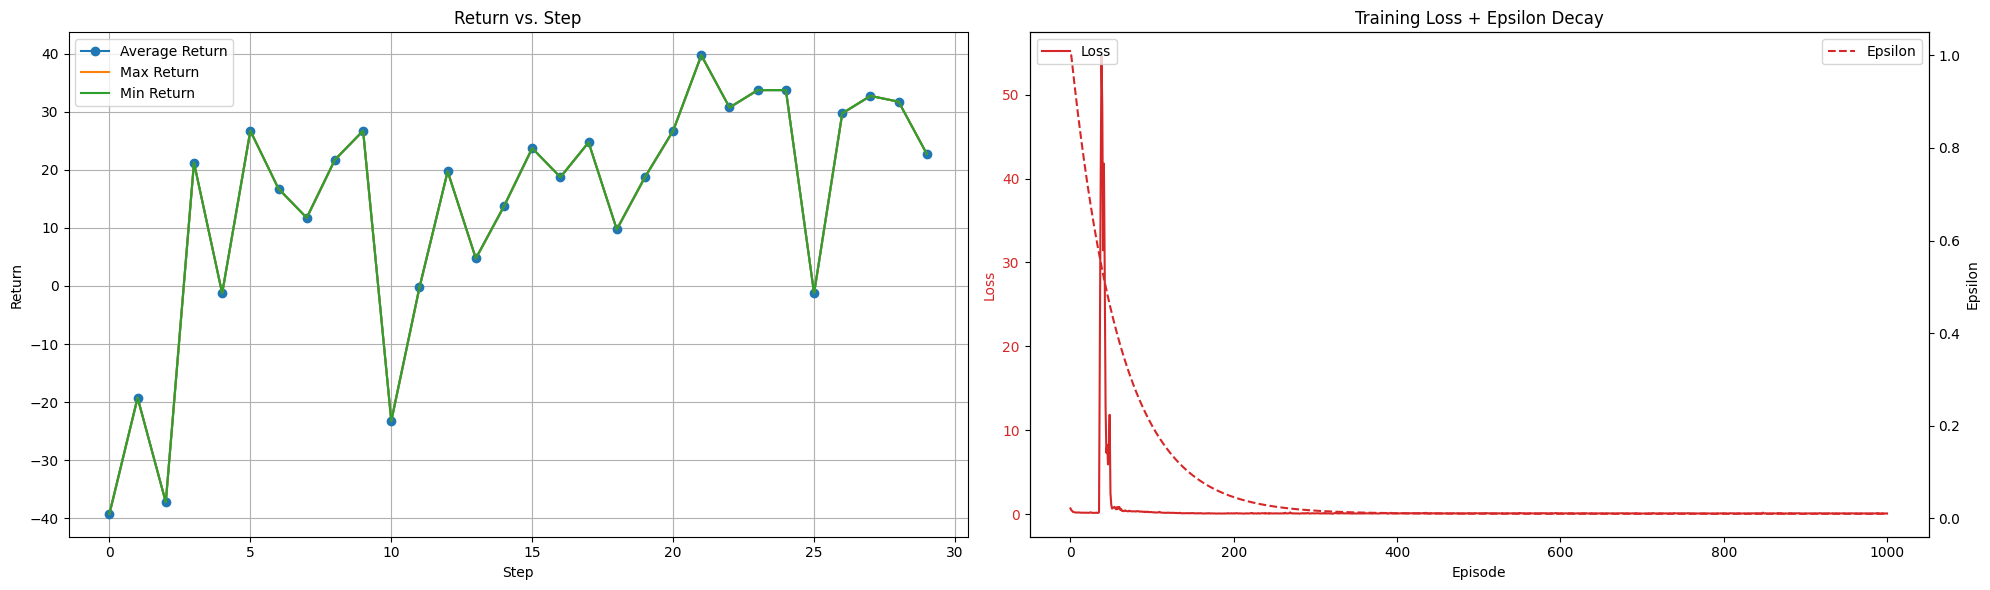

In [16]:
average_returns = [return_dict['AverageReturn'].numpy() for return_dict in returns]
min_returns = [return_dict['MinReturn'].numpy() for return_dict in returns]
max_returns = [return_dict['MaxReturn'].numpy() for return_dict in returns]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

steps = range(0, len(average_returns))
ax[0].plot(steps, average_returns, marker='o', label='Average Return')
ax[0].plot(steps, max_returns, label='Max Return')
ax[0].plot(steps, min_returns, label='Min Return')
ax[0].fill_between(steps, min_returns, max_returns, color='gray', alpha=0.3)  #
ax[0].set_ylabel('Return')
ax[0].set_xlabel('Step')
ax[0].set_title('Return vs. Step')
ax[0].grid(True)
ax[0].legend()

color = 'tab:red'
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Loss', color=color)
ax[1].plot(losses, color=color, label='Loss')
ax[1].tick_params(axis='y', labelcolor=color)

ax2 = ax[1].twinx()
ax2.set_ylabel('Epsilon')
ax2.plot(eps, color=color, linestyle='--', label='Epsilon')
ax2.tick_params(axis='y')
ax2.legend()
ax[1].set_title('Training Loss + Epsilon Decay')
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [17]:
if IN_COLAB:
    archive_path = shutil.make_archive("model_files", 'zip', root_dir='.', base_dir=f'{GDRIVE}/MyDrive/{policy_dir}')
    print(f"Archived {GDRIVE}/MyDrive/{archive_path}")
else:
    archive_path = shutil.make_archive("model_files", 'zip', root_dir='.', base_dir=policy_dir)
    print(f"Archived {policy_dir} into {archive_path}")

Archived ./models/policy into /kaggle/working/model_files.zip


In [18]:
print("Live episode started...")
tf_eval_policy = tf.saved_model.load(policy_dir)
time_step = tf_eval_env.reset()
while not time_step.is_last():
    action_step = tf_eval_policy.action(time_step)
    time_step = tf_eval_env.step(action_step.action)
print("...Live episode finished")

Live episode started...
...Live episode finished


In [19]:
import json

def numpy_int_handler(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    raise TypeError("Unserializable object {} of type {}".format(obj, type(obj)))


trade_stats  = eval_env.get_trade_stats()
file_path = os.path.join(policy_dir, "trade_stats.json")
with open(file_path, "w") as json_file:
    json.dumps(trade_stats, default=numpy_int_handler)

print(f"Trade statistics saved to {file_path}")

trade_stats

Trade statistics saved to ./models/policy/trade_stats.json


{'Annualized Return': 0.0007960722403048341,
 'Annualized Vol': 0.020559026194210385,
 'Sharpe Ratio': -2.3346833140517833,
 'Downside Deviation': 0.016954308937915306,
 'Sortino Ratio': -0.011234400081704976,
 'Max Drawdown': -0.02415067904454458,
 'Max Drawdown Days': 14,
 'Trade Churn': 0.0,
 'Skewness': -0.2445358727238994,
 'Kurtosis': 26.673587352537247}

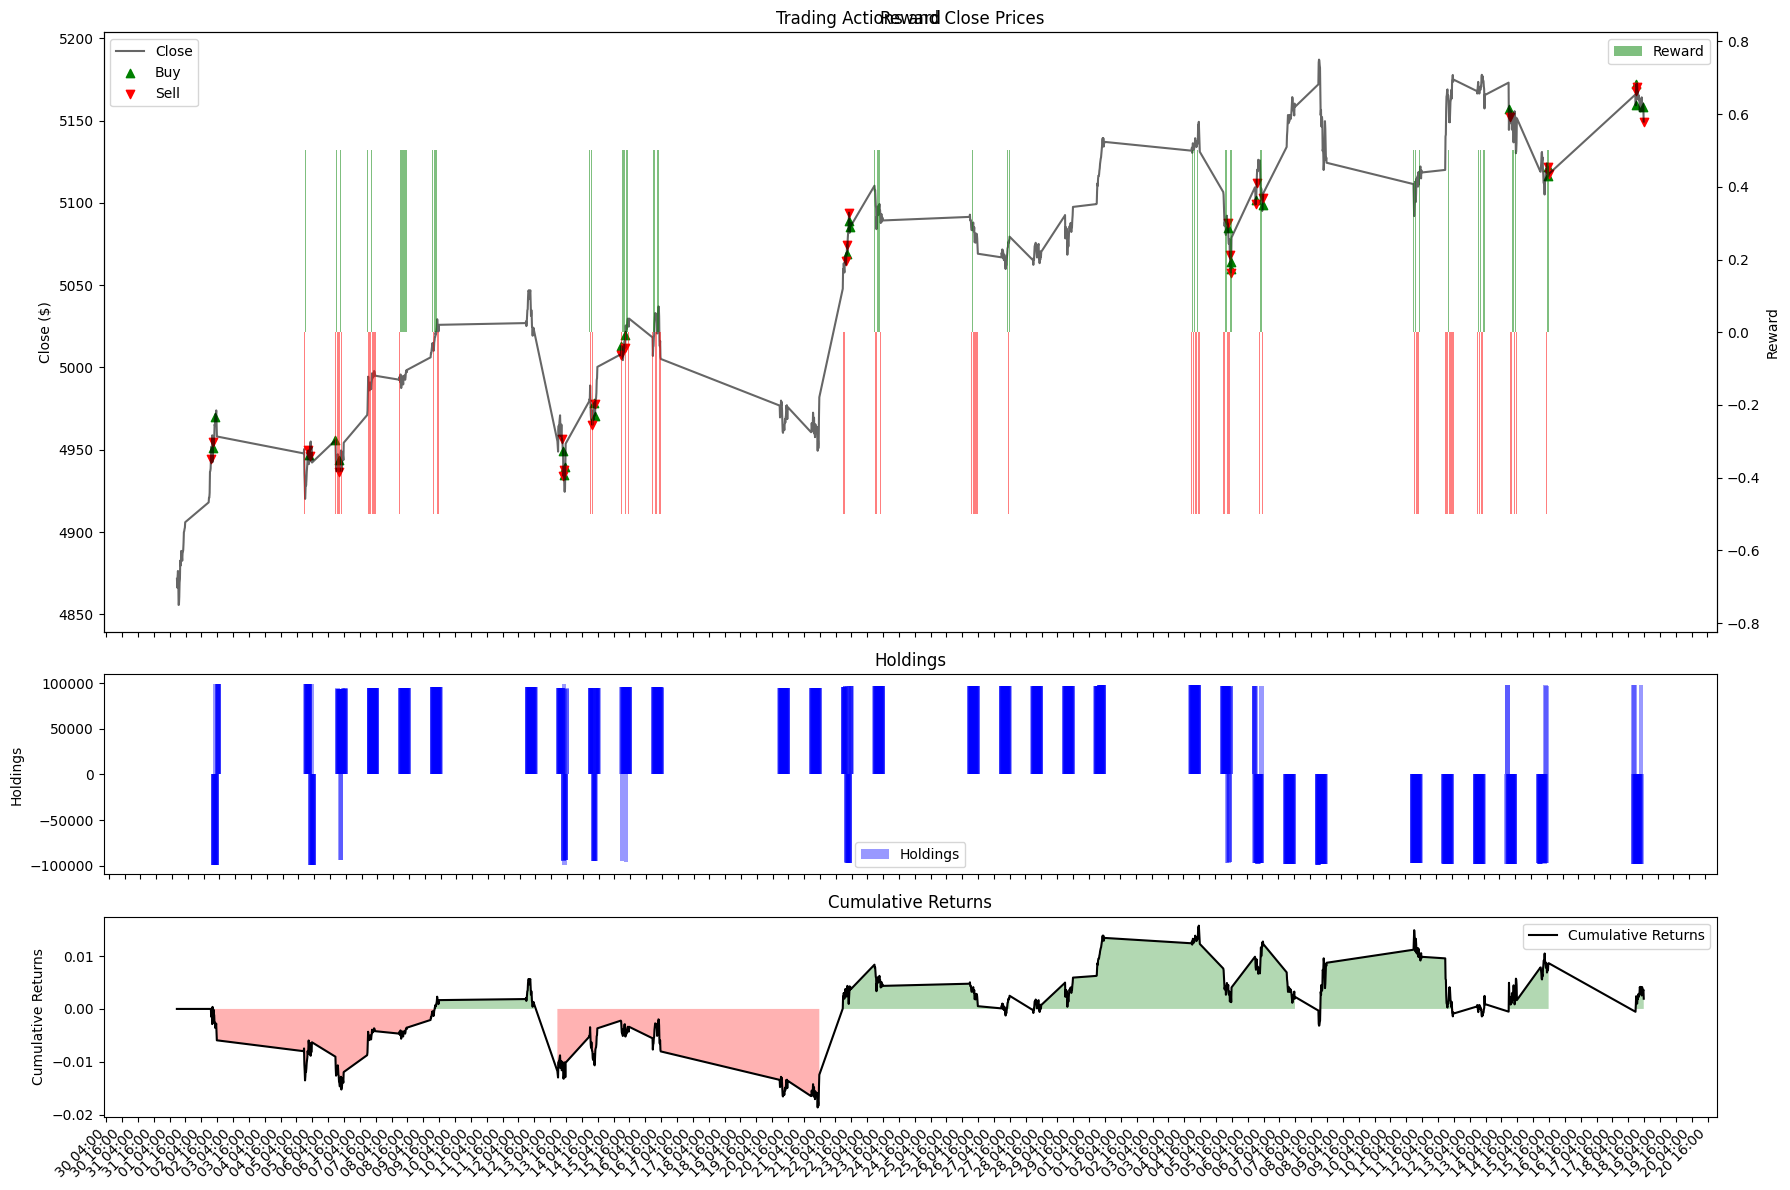

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = eval_env.data.copy()
data['Cumulative_Returns'] = np.cumprod(data["Returns"] + 1) - 1

fig, axs = plt.subplots(3, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

axs[0].plot(data.index, data[TARGET_FEATURE], label='Close', color='k', alpha=0.6)
buys = data[data['Action'] == ACT_LONG]
sells = data[data['Action'] == ACT_SHORT]
axs[0].scatter(buys.index, buys[TARGET_FEATURE], label='Buy', color='green', marker='^', alpha=1)
axs[0].scatter(sells.index, sells[TARGET_FEATURE], label='Sell', color='red', marker='v', alpha=1)
axs[0].set_ylabel('Close ($)')
axs[0].set_title('Trading Actions and Close Prices')
axs[0].legend()

axs[1].bar(data.index, data["Holdings"], label='Holdings', color='blue', alpha=0.4, width=0.15)
axs[1].set_ylabel('Holdings')
axs[1].set_title('Holdings')
axs[1].legend()

axs[2].plot(data.index, data['Cumulative_Returns'], label='Cumulative Returns', color='black')
axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] >= 0), facecolor='green', alpha=0.3)
axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] < 0), facecolor='red', alpha=0.3)
axs[2].set_ylabel('Cumulative Returns')
axs[2].set_title('Cumulative Returns')
axs[2].legend()

ax12 = axs[0].twinx()
reward_colors = ['green' if x >= 0 else 'red' for x in data['Reward']]
ax12.bar(data.index, data['Reward'], color=reward_colors, label='Reward', alpha=0.5, width=0.005)
ax12.set_ylabel('Reward')
ax12.set_title('Reward')
ax12.legend()

hours_locator = mdates.HourLocator(interval=12)
hours_formatter = mdates.DateFormatter('%d %H:%M')
for ax in axs:
    ax.xaxis.set_major_locator(hours_locator)
    ax.xaxis.set_major_formatter(hours_formatter)

fig.autofmt_xdate(rotation=45, ha='right')
plt.xlabel('Date')
plt.tight_layout()
plt.show()